In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os
'''gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)'''
pl = pd.read_csv('/home/ryan/Downloads/pd_1747687111.csv')
po = pd.read_csv('/home/ryan/Downloads/pd_1747687187.csv')

pl = pl.drop(pl.index[-6:])
pl['date'] = pd.to_datetime(pl['#date+time'])
po = po.drop(po.index[-6:])
po['date'] = pd.to_datetime(po['#date+time'])
pl = pl.drop(columns=['#date+time'])
po = po.drop(columns=['#date+time'])
main = pd.merge(pl, po, on='date', how='inner')
main.columns = ['pl_pwl','pl_bwl','pl_wsd','pl_wdr','date','po_pwl','po_bwl','po_wsd','po_wdr']
main = main.dropna().reset_index(drop=True)
main['pl_wdr'] = pd.to_numeric(main['pl_wdr'], errors='coerce')
main['pl_wsd'] = pd.to_numeric(main['pl_wsd'], errors='coerce')
main['po_wdr'] = pd.to_numeric(main['po_wdr'], errors='coerce')
main['po_wsd'] = pd.to_numeric(main['po_wsd'], errors='coerce')
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

main[['u_station_pl', 'v_station_pl']] = pd.DataFrame(
    np.column_stack(wind_to_uv(main['pl_wsd'], main['pl_wdr'])), 
    index=main.index
)

main[['u_station_po', 'v_station_po']] = pd.DataFrame(
    np.column_stack(wind_to_uv(main['po_wsd'], main['po_wdr'])), 
    index=main.index
)
main = main.drop(columns=['pl_wsd', 'po_wsd', 'pl_wdr', 'po_wdr'])

2025-05-20 16:36:35.526428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_24210/4075513652.py:12: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pl = pd.read_csv('/home/ryan/Downloads/pd_1747687111.csv')
/tmp/ipykernel_24210/4075513652.py:13: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  po = pd.read_csv('/home/ryan/Downloads/pd_1747687187.csv')


In [2]:
features = ['po_pwl', 'po_bwl', 'u_station_po', 'v_station_po']
main[features] = main[features].apply(pd.to_numeric, errors='coerce')
main['pl_pwl'] = pd.to_numeric(main['pl_pwl'], errors='coerce')
data_array = main[features + ['pl_pwl']].to_numpy(dtype=np.float32)
window_size = 10
n_samples = len(data_array) - window_size

X = np.empty((n_samples, window_size, len(features)), dtype=np.float32)
y = np.empty(n_samples, dtype=np.float32)

for i in range(n_samples):
    window = data_array[i:i+window_size, :-1]  # shape (10, 4)
    target = data_array[i+window_size, -1]     # target pl_pwl at t+10
    if not np.isnan(window).any() and not np.isnan(target):
        X[i] = window
        y[i] = target
    else:
        X[i] = np.nan
        y[i] = np.nan

# Remove invalid samples
mask = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y)
X = X[mask]
y = y[mask]

print("LSTM Input Shape:", X.shape)  # Should be (samples, 10, 4)

LSTM Input Shape: (423559, 10, 4)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reshape to 2D for scaling: (samples × time, features)
X_2d = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled_2d = scaler.fit_transform(X_2d)
X_scaled = X_scaled_2d.reshape(X.shape)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, 4)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=512)


2025-05-20 16:36:43.272669: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:36:45.523787: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:36:45.523858: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:36:45.525165: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:36:45.525276: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/50


I0000 00:00:1747777007.076719   24288 service.cc:146] XLA service 0x707c34002d10 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747777007.076755   24288 service.cc:154]   StreamExecutor device (0): Radeon RX 7900 GRE, AMDGPU ISA version: gfx1100
2025-05-20 16:36:47.093043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 25/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0507 - mae: 0.1715  

I0000 00:00:1747777008.566588   24288 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0114 - mae: 0.0644 - val_loss: 0.0054 - val_mae: 0.0379
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093 - mae: 0.0365 - val_loss: 0.0956 - val_mae: 0.0357
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - mae: 0.0346 - val_loss: 0.0098 - val_mae: 0.0348
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - mae: 0.0345 - val_loss: 0.0027 - val_mae: 0.0345
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0333 - val_loss: 0.0019 - val_mae: 0.0326
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mae: 0.0326 - val_loss: 0.0076 - val_mae: 0.0327
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0022 - val_mae: 0.0331
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - mae: 0.0325 - val_loss: 0.0120 - val_mae: 0.0324
Epoch 9/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 

2648/2648 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0015 - mae: 0.0290
Test MSE: 0.0015, MAE: 0.0290
2648/2648 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


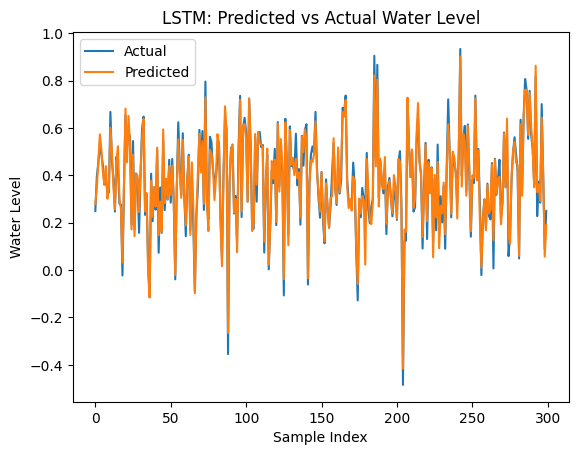

In [5]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss:.4f}, MAE: {mae:.4f}")

# Predictions
y_pred = model.predict(X_test).flatten()

# Plot
import matplotlib.pyplot as plt

plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred[:300], label='Predicted')
plt.legend()
plt.title("LSTM: Predicted vs Actual Water Level")
plt.xlabel("Sample Index")
plt.ylabel("Water Level")
plt.show()
